In [1]:
import dynamo as dyn
import numpy as np
import re
import pandas as pd
import scvelo as scv
import scanpy as sc
from sklearn.cluster import KMeans
from sklearn import preprocessing
from collections import Counter
from dante_functions import *
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt 
%matplotlib inline

/home/dap182/anaconda3/envs/kb/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
#this is the unprocessed 3567 x 33694 loom or h5ad of only a549 cells, whichever you have 
adata=dyn.read_loom('data/a549_tgfb1.loom')
meta=pd.read_csv('data/a549_tgfb1_meta.csv')

## Adds treatment information to data ##

In [3]:
CellIDs=np.array(meta["Unnamed: 0"])+'x'
for ID in range(len(CellIDs)):
    #This is needed to make the cell ids have the same syntax as the loom files 
    CellIDs[ID]=re.sub('x',"x-",CellIDs[ID],count=1)
    CellIDs[ID]=re.sub('_',":",CellIDs[ID])

meta['Unnamed: 0']=CellIDs

cells=meta['Unnamed: 0'].to_numpy()

treatment=np.array([[meta['Time'][np.squeeze(np.argwhere(cells==cell))]][0] for cell in adata.obs_names])

adata.obs['treatment']=treatment

adata

AnnData object with n_obs × n_vars = 3567 × 33694 
    obs: 'Clusters', '_X', '_Y', 'batch', 'treatment'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

## Isolating cytoskeleton genes ##

In [4]:
cyto_gene_list=np.loadtxt('gene_lists/cytoskeleton_genes.txt',dtype=str)

gene_idxs=np.hstack([np.where(adata.var_names==i)[0] for i in cyto_gene_list])

adata_cyto=adata[:,gene_idxs]

adata_cyto

View of AnnData object with n_obs × n_vars = 3567 × 360 
    obs: 'Clusters', '_X', '_Y', 'batch', 'treatment'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

## Isolating EMT genes ##

In [5]:
emt_gene_list=np.loadtxt('gene_lists/emt_genes_weikang.txt',dtype=str)

gene_idxs=np.hstack([np.where(adata.var_names==i)[0] for i in emt_gene_list])

adata_emt=adata[:,gene_idxs]

adata_emt

View of AnnData object with n_obs × n_vars = 3567 × 308 
    obs: 'Clusters', '_X', '_Y', 'batch', 'treatment'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

## Seperation of data based on treatment time ##

In [6]:
#stable_emt = se
stable_emt=['0d','8h','1d','3d','7d']

boolean_cyto=np.isin(adata_cyto.obs['treatment'].values,stable_emt)
se_idx_cyto=np.squeeze(np.argwhere(boolean_cyto==True))

boolean_emt=np.isin(adata_emt.obs['treatment'].values,stable_emt)
se_idx_emt=np.squeeze(np.argwhere(boolean_emt==True))

In [7]:
se_adata_cyto=adata_cyto[se_idx_cyto,:]
se_adata_emt=adata_emt[se_idx_emt,:]

print('Cyto Raw Data')
print('--------------------------------------------')
print(se_adata_cyto)
print()
print('EMT Raw Data')
print('--------------------------------------------')
print(se_adata_emt)
print()

Cyto Raw Data
--------------------------------------------
View of AnnData object with n_obs × n_vars = 3132 × 360 
    obs: 'Clusters', '_X', '_Y', 'batch', 'treatment'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

EMT Raw Data
--------------------------------------------
View of AnnData object with n_obs × n_vars = 3132 × 308 
    obs: 'Clusters', '_X', '_Y', 'batch', 'treatment'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'



## Stable and EMT Data (0d, 8h, 1d, 3d, 7d)

### scVelo preprocessing ###

In [8]:
scv.pp.filter_and_normalize(se_adata_cyto)
scv.pp.moments(se_adata_cyto)

scv.pp.filter_and_normalize(se_adata_emt)
scv.pp.moments(se_adata_emt)

Trying to set attribute `.obs` of view, copying.


Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors


Trying to set attribute `.obs` of view, copying.


    finished (0:00:02) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)


### scVelo velocity processing ###

In [9]:
scv.tl.velocity(se_adata_cyto)
scv.tl.velocity_graph(se_adata_cyto)
scv.tl.umap(se_adata_cyto)

scv.tl.velocity(se_adata_emt)
scv.tl.velocity_graph(se_adata_emt)
scv.tl.umap(se_adata_emt)

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


### scVelo visualization ###

computing velocity embedding
    finished (0:00:01) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)


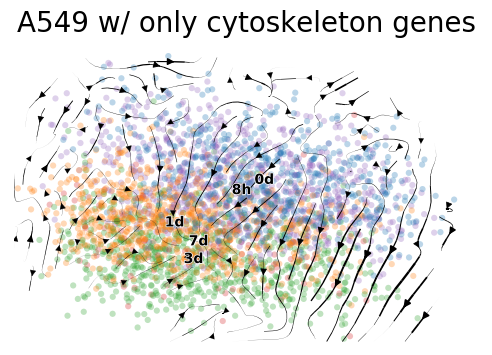

computing velocity embedding
    finished (0:00:01) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)


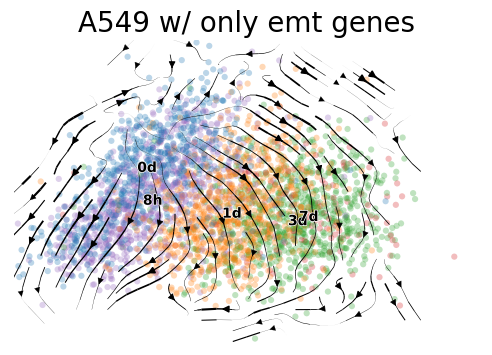

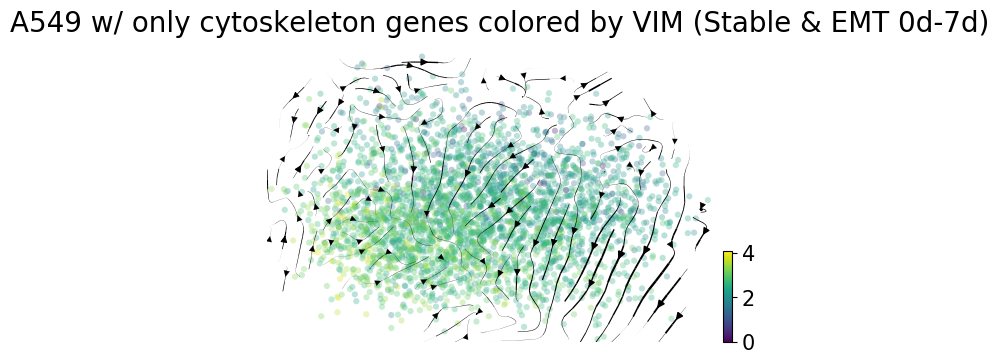

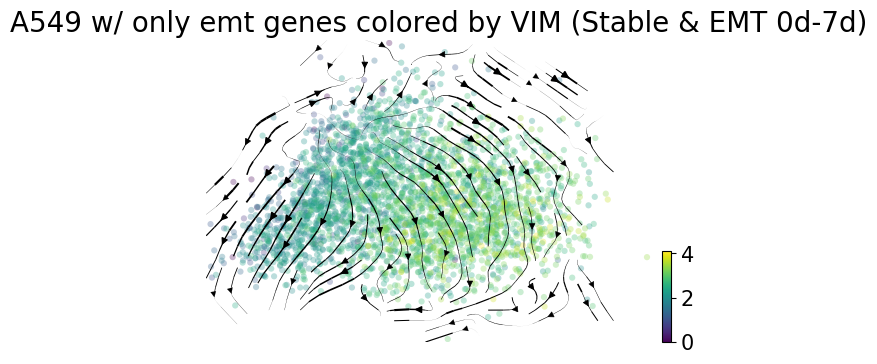

In [10]:
scv.pl.velocity_embedding_stream(se_adata_cyto, basis='pca',color='treatment',figsize=(6,4),
                                 title='A549 w/ only cytoskeleton genes',
                                fontsize=20,smooth=1,dpi=100,size=80,density=0.5)

scv.pl.velocity_embedding_stream(se_adata_emt, basis='pca',color='treatment',figsize=(6,4),
                                 title='A549 w/ only emt genes',
                                fontsize=20,smooth=1,dpi=100,size=80,density=0.5)

scv.pl.velocity_embedding_stream(se_adata_cyto, basis='pca',color='VIM',figsize=(6,4),
                                 title='A549 w/ only cytoskeleton genes colored by VIM (Stable & EMT 0d-7d)',
                                legend_loc='right margin',fontsize=20,
                                 legend_fontsize=15,smooth=1,dpi=100,size=80,density=0.5)

scv.pl.velocity_embedding_stream(se_adata_emt, basis='pca',color='VIM',figsize=(6,4),
                                 title='A549 w/ only emt genes colored by VIM (Stable & EMT 0d-7d)',
                                legend_loc='right margin',fontsize=20,
                                 legend_fontsize=15,smooth=1,dpi=100,size=80,density=0.5)

## Plotting 3D velocity

In [11]:
def plot_X(X, dim1=0, dim2=1, create_figure=False, figsize=(6, 6), **kwargs):
    if create_figure:
        plt.figure(figsize=figsize)
    plt.scatter(X[:, dim1], X[:, dim2], **kwargs)
    
def plot_V(X, V, dim1=0, dim2=1, create_figure=False, figsize=(6, 6), **kwargs):
    if create_figure:
        plt.figure(figsize=figsize)
    plt.quiver(X[:, dim1], X[:, dim2], V[:, dim1], V[:, dim2])
    
def color_set(data,gene):
    gene_idx=np.where(data.var_names==gene)[0][0]
    c=np.squeeze(np.asarray(data.X[:,gene_idx].todense()))
    return c

def color_treatment(adata):
    le=preprocessing.LabelEncoder()
    treatment=adata.obs['treatment'].values
    uniq_labels=np.unique(treatment)
    labels=le.fit(uniq_labels)
    classes=le.classes_
    encoded=le.transform(treatment)
    print(le.get_params())
    return encoded,le

In [12]:
colors,le=color_treatment(se_adata_emt)

colors=np.divide(colors,4).astype('str')

colors[colors=="0.0"]='r'
r=mpatches.Patch(color='r',label='0d')

colors[colors=="1.0"]='c'
c=mpatches.Patch(color='c',label='8h')

colors[colors=="0.25"]='g'
g=mpatches.Patch(color='g',label='1d')

colors[colors=="0.5"]='b'
b=mpatches.Patch(color='b',label='3d')

colors[colors=="0.75"]='m'
m=mpatches.Patch(color='m',label='7d')

{}


In [13]:
X=se_adata_emt.obsm['X_pca'][:,0]
Y=se_adata_emt.obsm['X_pca'][:,1]
Z=se_adata_cyto.obsm['X_pca'][:,0]

<IPython.core.display.Javascript object>


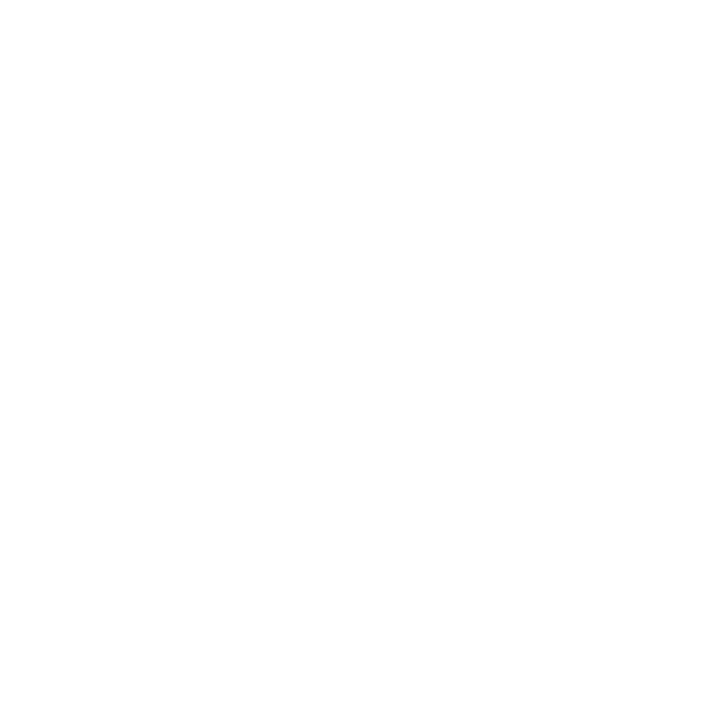

Text(0.5, 0, 'PC-1 Cyto')

<IPython.core.display.Javascript object>


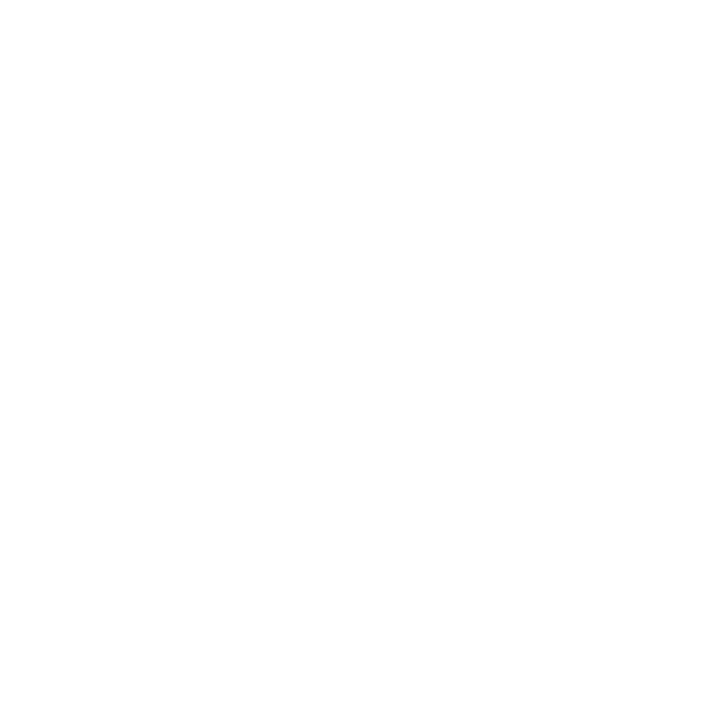

In [14]:
%matplotlib notebook

fig = plt.figure( figsize=(10,10))
ax = fig.add_subplot(111,projection='3d')

ax.scatter(X, Y, Z, color=colors, marker='o',s=3,alpha=0.3)
#ax.legend()
ax.legend(handles=[r,c,g,b,m],labels=['0d','8h','1d','3d','7d'])
ax.set_xlabel('PC-1 EMT')
ax.set_ylabel('PC-2 EMT')
ax.set_zlabel('PC-1 Cyto')

In [18]:
coords=np.column_stack([X,Y,Z])

cluster_num=100

kmeans=KMeans(n_clusters=cluster_num,random_state=0).fit(coords)

cluster_centers=kmeans.cluster_centers_

labels=kmeans.labels_

X_velocity=se_adata_emt.obsm['velocity_pca'][:,0]
Y_velocity=se_adata_emt.obsm['velocity_pca'][:,1]
Z_velocity=se_adata_cyto.obsm['velocity_pca'][:,0]

velocity_matrix=np.column_stack([X_velocity,Y_velocity,Z_velocity])

cluster_velocities=np.zeros_like(cluster_centers)
cluster_treatment_times=[]
for label in range(cluster_num):
    boolean_list=np.argwhere(labels==label).squeeze()
    members=se_adata_emt.obs['treatment'].values[boolean_list].to_numpy()
    cluster_treatment=Counter(members).most_common()[0][0]
    cluster_treatment_times.append(cluster_treatment)
    
    member_velocities=velocity_matrix[boolean_list]
    mean_velocity_vector=np.mean(member_velocities,axis=0)
    cluster_velocities[label]=mean_velocity_vector
    
Counter(cluster_treatment_times)
    

Counter({'1d': 24, '3d': 32, '8h': 31, '0d': 13})

In [19]:
cluster_colors=np.array(cluster_treatment_times,dtype=str)
cluster_treatment_times=np.array(cluster_treatment_times)

cluster_colors[cluster_treatment_times=="0d"]='r'
r=mpatches.Patch(color='r',label='0d')
cluster_colors[cluster_treatment_times=="8h"]='c'
c=mpatches.Patch(color='c',label='8h')
cluster_colors[cluster_treatment_times=="1d"]='g'
g=mpatches.Patch(color='g',label='1d')
cluster_colors[cluster_treatment_times=="3d"]='y'
y=mpatches.Patch(color='y',label='3d')
cluster_colors[cluster_treatment_times=="7d"]='m'
m=mpatches.Patch(color='m',label='7d')

<IPython.core.display.Javascript object>


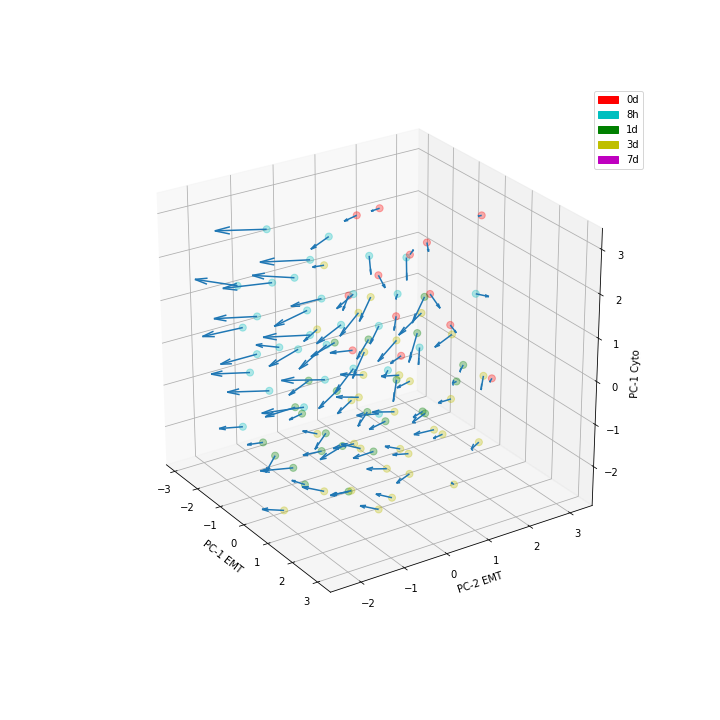

Text(0.5, 0, 'PC-1 Cyto')

In [20]:
%matplotlib notebook

fig = plt.figure( figsize=(10,10))
ax = fig.gca(projection='3d')

X_k=cluster_centers[:,0]
Y_k=cluster_centers[:,1]
Z_k=cluster_centers[:,2]

ax.scatter(X_k, Y_k, Z_k, marker='o',color=cluster_colors,s=50,alpha=0.3)
ax.quiver(X_k,Y_k,Z_k,cluster_velocities[:,0],cluster_velocities[:,1],cluster_velocities[:,2],length=30)
ax.legend(handles=[r,c,g,y,m],labels=['0d','8h','1d','3d','7d'])
ax.set_xlabel('PC-1 EMT')
ax.set_ylabel('PC-2 EMT')
ax.set_zlabel('PC-1 Cyto')